In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy
import pandas
import os

import pickle
def fnSaveObject(save_object, sFileName):
    with open(sFileName, "wb") as file:
        pickle.dump(save_object, file)

def fnLoadObject(sFileName):
    with open(sFileName, 'rb') as file:
        load_object = pickle.load(file)
    return load_object

# load ML model, list of contained SANS models, and their parameter names (list of lists)
dirname = 'ml_model'
sans_models = fnLoadObject(os.path.join(dirname, 'sans_models.dat'))
par_names = fnLoadObject(os.path.join(dirname, 'par_names.dat'))
# Load model for prediction. Compile = False avoids supplying the custom loss function.
ml_model = tf.keras.models.load_model(dirname, compile=False)


In [7]:
def plot(data):
    fig, ax = plt.subplots()

    ax.errorbar(data['Q'], data['I'], data['dI'], ls='none', color='deepskyblue')
    ax.scatter(data['Q'], data['I'], s=30, marker='o', facecolors='none', edgecolors='deepskyblue', label='sim')

    ax.legend(fontsize=16)
    ax.set_ylabel("I (1/cm)", fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in", labelsize=16)
    ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
    ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=16)
    ax.figure.set_size_inches(8, 5)
    #ax.set_ylim(1e-2, .1)
    plt.tight_layout()
    plt.show()


def predict(filename, ml_model, supplement_input=None, background=0):
    print(filename)
    print("")

    data = pandas.read_csv(filename, skiprows=1, names=['Q', 'I', 'dI', 'dQ', 'c1', 'c2'], delimiter='\s+')
    print(data)
    plot(data)

    data['I'] -= background
    print('After background subtraction:')
    plot(data)

    # interpolation of SANS data to hardcoded grid
    qmin = 0.01
    qmax = 0.8
    numpoints = int((numpy.log10(qmax) - numpy.log10(qmin)) * 60)
    qvec = numpy.logspace(numpy.log10(qmin), numpy.log10(qmax), num=numpoints, endpoint=True)
    qvec = qvec[:105]

    qvec_data = data['Q'].to_numpy()
    intensity_data = data['I'].to_numpy()
    # intensity_data -= background
    intensity_data = numpy.log10(numpy.abs(intensity_data))

    intensity = numpy.interp(qvec, qvec_data, intensity_data)
    intensity = intensity[numpy.newaxis, :]
    intensity = tf.convert_to_tensor(intensity, dtype=tf.float32)

    sup = numpy.array(supplement_input).astype('float32')
    sup = sup[numpy.newaxis, :]

    print(intensity.shape, sup.shape)

    y_pred = ml_model.predict([intensity, sup])

    print("")
    print("---Classification---")
    for i, model in enumerate(sans_models):
        print(model, f'{y_pred[-1][0][i]:.2f}')
    print("")

    print("---Regression---")
    for i in range(len(y_pred)-1):
        print("Model: ", sans_models[i])
        for j in range(len(par_names[i])):
            parname = par_names[i][j]
            if 'sld' in parname:
                correction = 0.1
            else:
                correction = 1
            print(parname, y_pred[i][0][j]*correction)
        print("")




validation_exps/5LysNaCl.sub

            Q         I        dI        dQ        c1        c2
0    0.003361  0.638534  0.080910  0.001038  0.004201  0.000503
1    0.003756  0.394159  0.060022  0.001040  0.004241  0.091110
2    0.004151  0.312985  0.048316  0.001048  0.004362  0.732700
3    0.004547  0.185027  0.043140  0.001060  0.004663  0.995000
4    0.004942  0.169852  0.035228  0.001064  0.005047  1.000000
..        ...       ...       ...       ...       ...       ...
247  0.552400  0.000655  0.001151  0.031090  0.552400  1.000000
248  0.556000 -0.001455  0.001021  0.031280  0.556000  1.000000
249  0.559500  0.001144  0.001864  0.031470  0.559500  1.000000
250  0.563100  0.001615  0.001759  0.031670  0.563100  1.000000
251  0.566600 -0.002736  0.001964  0.031860  0.566600  1.000000

[252 rows x 6 columns]


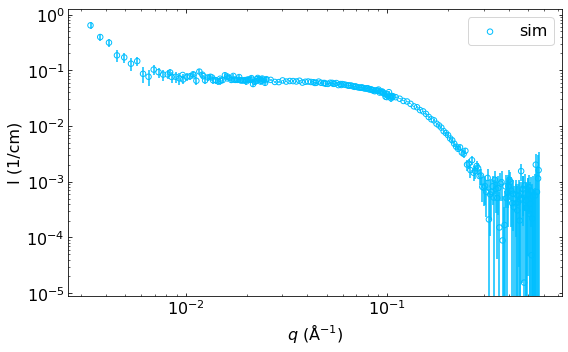

After background subtraction:


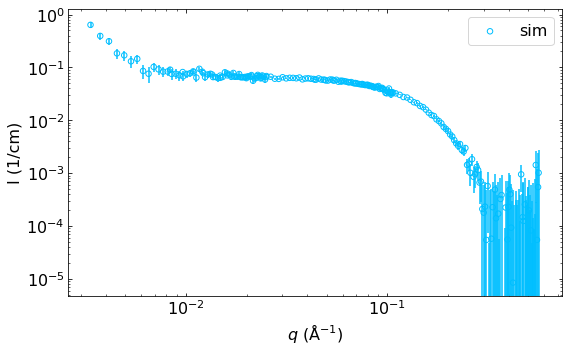

(1, 105) (1, 2)
1/1 [==============================] - 1s 890ms/step

---Classification---
sphere 0.41
core_shell_sphere 0.09
ellipsoid 0.03
core_shell_ellipsoid 0.01
cylinder 0.02
core_shell_cylinder 0.05
three_pearl_necklace 0.12
lamellar 0.00
lamellar_hg 0.28

---Regression---
Model:  sphere
radius 19.840038299560547
sld 2.679861450195313

Model:  core_shell_sphere
radius 18.755895614624023
sld_core 1.6289388656616213
sld_shell 5.861554336547852
thickness 23.61321258544922

Model:  ellipsoid
radius_equatorial 18.910301208496094
radius_polar 20.80028533935547
sld 1.0181286811828614

Model:  core_shell_ellipsoid
radius_equat_core 34.41188049316406
sld_core 1.5266974449157715
sld_shell 7.068246459960938
thick_shell 30.067312240600586
x_core 4.550766468048096
x_polar_shell 4.871516227722168

Model:  cylinder
length 30.20134162902832
radius 15.802872657775879
sld 3.515970230102539

Model:  core_shell_cylinder
length 74.97006225585938
radius 21.73455047607422
sld_core 2.7077178955078125
s

In [5]:
predict('validation_exps/5LysNaCl.sub', ml_model, supplement_input=[0.002, 6.4], background=6e-4)

validation_exps/DMPC_D2O.ABS

            Q          I         dI        dQ        c1  c2
0    0.001418  217.90000  14.620000  0.000233  0.001436   1
1    0.001676  227.90000  12.000000  0.000236  0.001691   1
2    0.001934  222.10000  10.500000  0.000240  0.001947   1
3    0.002192  224.60000  10.280000  0.000245  0.002203   1
4    0.002450  225.00000  10.860000  0.000250  0.002460   1
..        ...        ...        ...       ...       ...  ..
221  0.481500    0.06010   0.001253  0.023250  0.481500   1
222  0.485600    0.06372   0.001201  0.023440  0.485700   1
223  0.489700    0.06496   0.001205  0.023620  0.489800   1
224  0.493800    0.06432   0.001262  0.023810  0.493900   1
225  0.497900    0.06209   0.001326  0.023990  0.497900   1

[226 rows x 6 columns]


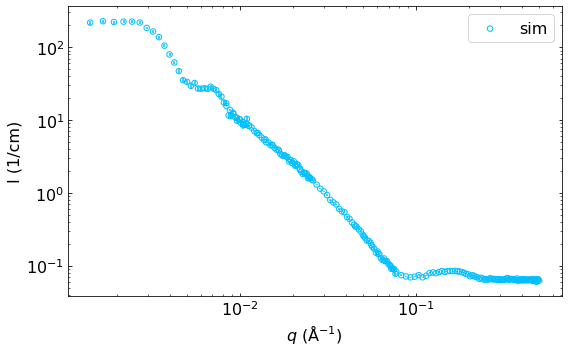

After background subtraction:


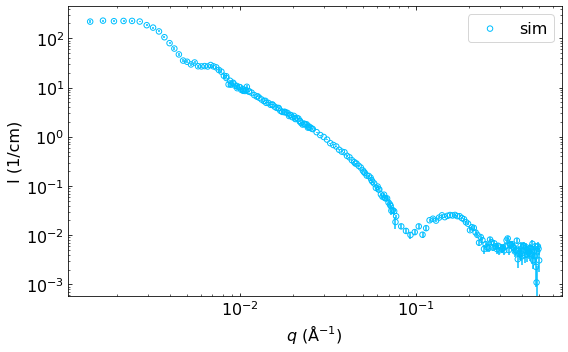

(1, 105) (1, 2)
1/1 [==============================] - 0s 24ms/step

---Classification---
sphere 0.00
core_shell_sphere 0.00
ellipsoid 0.00
core_shell_ellipsoid 0.04
cylinder 0.00
core_shell_cylinder 0.00
three_pearl_necklace 0.00
lamellar 0.04
lamellar_hg 0.93

---Regression---
Model:  sphere
radius 105.69815063476562
sld 3.2940547943115237

Model:  core_shell_sphere
radius 99.40190124511719
sld_core -0.6692631721496582
sld_shell 7.380056762695313
thickness 108.43172454833984

Model:  ellipsoid
radius_equatorial 173.54055786132812
radius_polar 49.28545379638672
sld 4.456874847412109

Model:  core_shell_ellipsoid
radius_equat_core 116.64359283447266
sld_core 5.343180847167969
sld_shell 3.7442878723144535
thick_shell 47.97282409667969
x_core 5.438464164733887
x_polar_shell 5.544321060180664

Model:  cylinder
length 65.12484741210938
radius 159.1087646484375
sld 4.407752227783203

Model:  core_shell_cylinder
length 62.80962371826172
radius 148.68043518066406
sld_core 3.304133224487305
sl

In [5]:
predict('validation_exps/DMPC_D2O.ABS', ml_model, supplement_input=[0.002, 6.2], background=0.059)

validation_exps/DMPC_H2O.ABS

            Q         I         dI        dQ        c1  c2
0    0.001418  2349.000  62.740000  0.000233  0.001436   1
1    0.001676  2363.000  53.400000  0.000236  0.001691   1
2    0.001934  2409.000  62.220000  0.000240  0.001947   1
3    0.002192  2288.000  54.990000  0.000245  0.002203   1
4    0.002450  2150.000  46.670000  0.000250  0.002460   1
..        ...       ...        ...       ...       ...  ..
222  0.481500     1.089   0.008626  0.023250  0.481500   1
223  0.485600     1.091   0.006889  0.023440  0.485700   1
224  0.489700     1.082   0.008576  0.023620  0.489800   1
225  0.493800     1.094   0.007891  0.023810  0.493900   1
226  0.497900     1.094   0.007157  0.023990  0.497900   1

[227 rows x 6 columns]


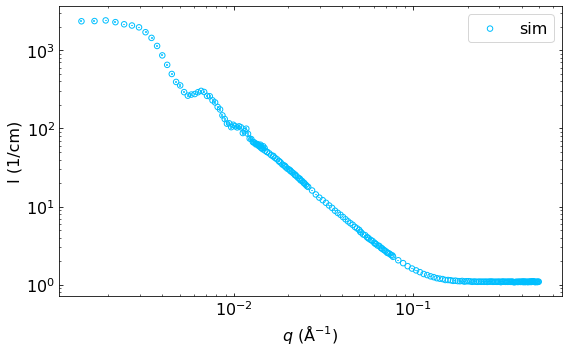

After background subtraction:


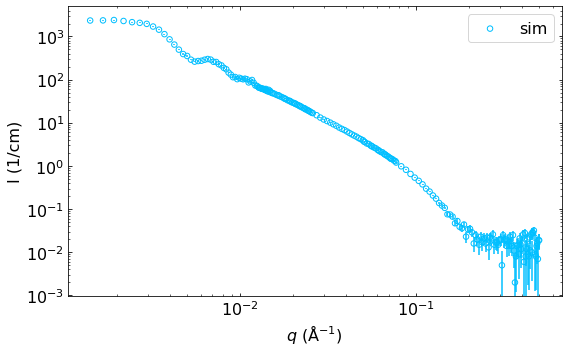

(1, 105) (1, 2)
1/1 [==============================] - 0s 25ms/step

---Classification---
sphere 0.00
core_shell_sphere 0.00
ellipsoid 0.00
core_shell_ellipsoid 0.00
cylinder 0.00
core_shell_cylinder 0.00
three_pearl_necklace 0.00
lamellar 0.31
lamellar_hg 0.69

---Regression---
Model:  sphere
radius 108.85382843017578
sld 5.766794586181641

Model:  core_shell_sphere
radius 98.49556732177734
sld_core 6.842874908447266
sld_shell 0.2679306507110596
thickness 102.69551849365234

Model:  ellipsoid
radius_equatorial 174.37525939941406
radius_polar 21.000003814697266
sld 5.030895614624024

Model:  core_shell_ellipsoid
radius_equat_core 126.2647476196289
sld_core 1.6986087799072267
sld_shell 4.948056793212891
thick_shell 27.371185302734375
x_core 5.8425774574279785
x_polar_shell 5.659769535064697

Model:  cylinder
length 44.87125778198242
radius 165.82376098632812
sld 5.386139678955079

Model:  core_shell_cylinder
length 36.776329040527344
radius 172.97616577148438
sld_core 4.150050354003906


In [9]:
predict('validation_exps/DMPC_H2O.ABS', ml_model, supplement_input=[0.001, -0.5], background=1.075)

validation_exps/CMSA5.ABS

            Q        I        dI        dQ        c1      c2
0    0.003069  1.77100  0.250500  0.001078  0.003434  0.4038
1    0.003478  2.27700  0.190100  0.001089  0.003655  0.9565
2    0.003888  2.89100  0.142700  0.001093  0.004030  0.9999
3    0.004297  2.76200  0.114100  0.001095  0.004425  1.0000
4    0.004706  2.56000  0.089910  0.001097  0.004823  1.0000
..        ...      ...       ...       ...       ...     ...
246  0.556800  0.05061  0.001298  0.031360  0.556800  1.0000
247  0.560500  0.04926  0.000943  0.031570  0.560500  1.0000
248  0.564300  0.04799  0.001374  0.031770  0.564300  1.0000
249  0.568000  0.04918  0.001354  0.031970  0.568000  1.0000
250  0.571700  0.04681  0.001814  0.032170  0.571700  1.0000

[251 rows x 6 columns]


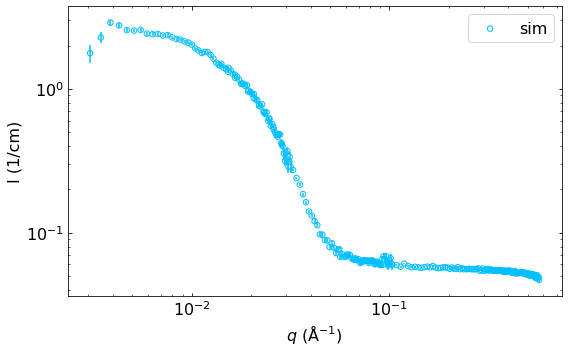

After background subtraction:


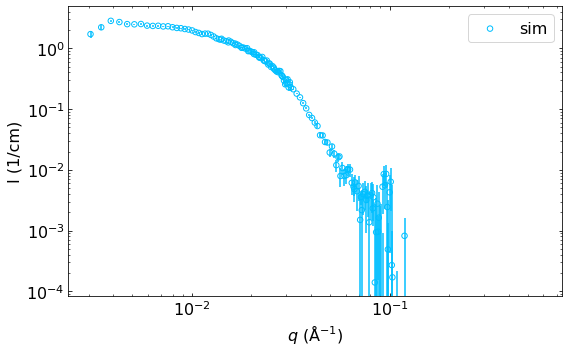

(1, 105) (1, 2)
1/1 [==============================] - 0s 21ms/step

---Classification---
sphere 0.00
core_shell_sphere 0.00
ellipsoid 0.71
core_shell_ellipsoid 0.06
cylinder 0.17
core_shell_cylinder 0.06
three_pearl_necklace 0.00
lamellar 0.00
lamellar_hg 0.00

---Regression---
Model:  sphere
radius 105.71002197265625
sld 2.4762596130371097

Model:  core_shell_sphere
radius 67.37004089355469
sld_core -2.2294029235839843
sld_shell 6.46378173828125
thickness 89.28184509277344

Model:  ellipsoid
radius_equatorial 126.11772155761719
radius_polar 58.899070739746094
sld 4.862468338012696

Model:  core_shell_ellipsoid
radius_equat_core 73.66600036621094
sld_core 2.328822708129883
sld_shell 5.090913009643555
thick_shell 43.159339904785156
x_core 5.170947074890137
x_polar_shell 6.011691570281982

Model:  cylinder
length 114.4692611694336
radius 107.75371551513672
sld 4.6962425231933596

Model:  core_shell_cylinder
length 43.98379135131836
radius 88.2685775756836
sld_core 2.515942001342774
sld_

In [10]:
predict('validation_exps/CMSA5.ABS', ml_model, supplement_input=[0.002, 4.5], background=0.06)